In [1]:
import numpy as np
import os
import torch
import torch.nn as nn
import time
import pandas as pd
from scipy.stats import pearsonr

In [2]:
from model.util import Normalizer
from model.database_util import get_hist_file, get_job_table_sample, collator
from model.model import QueryFormer
from model.database_util import Encoding
from model.dataset import PlanTreeDataset
from model.trainer import eval_workload, train

In [3]:
data_path = './data/imdb/'

In [4]:
class Args:
    bs = 128  # Batch size for training (number of samples per batch).
    lr = 0.001  # Learning rate controlling weight updates.
    epochs = 100  # Number of times the model trains on the entire dataset.
    clip_size = 50  # Gradient clipping to prevent exploding gradients.
    embed_size = 64  # Size of embedding vectors for input features.
    pred_hid = 128  # Number of hidden units in the prediction layer.
    ffn_dim = 128  # Size of the feed-forward network layer.
    head_size = 12  # Number of attention heads in the model.
    n_layers = 8  # Number of layers in the model.
    dropout = 0.1  # Dropout rate to prevent overfitting.
    sch_decay = 0.6  # Learning rate scheduler decay factor.
    device = 'cuda:0'  # Device for computation (GPU if available).
    newpath = './results/full/knobs_and_cost/'  # Path to save results.
    to_predict = 'both'  # Specifies the prediction target ('cost', 'knobs', or 'both').
    knob_column = 'Node Type'  # Column name representing the knob type.

args = Args()

# Ensure the results directory exists
import os
if not os.path.exists(args.newpath):
    os.makedirs(args.newpath)  # Creates the directory if it doesn't exist.


In [5]:
# Load the histogram file
hist_file = get_hist_file(data_path + 'histogram_string.csv')
# Normalizer for cost
cost_norm = Normalizer(-3.61192, 12.290855)
# Normalizer for cardinality
card_norm = Normalizer(1, 100)
# Normalizer for knob settings (if applicable)
knob_norm = Normalizer(0, 1)  # Adjust ranges based on your knob setting values


e:\KHU\Research\QueryFormer\QueryFormer\model\database_util.py:76: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  hist_file['freq'][i] = freq_np
e:\KHU\Research\QueryFormer\QueryFormer\model\database_util.py:89: FutureWarning: ChainedAssignme

In [6]:
encoding_ckpt = torch.load('checkpoints/encoding.pt')  # Loads the saved encoding checkpoint from a file.
encoding = encoding_ckpt['encoding']  # Extracts the 'encoding' object from the checkpoint.
checkpoint = torch.load('checkpoints/cost_model.pt', map_location='cpu')  # Loads the saved cost model checkpoint and maps it to CPU.


C:\Users\Hashmi\AppData\Local\Temp\ipykernel_27188\146086392.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  encoding_ckpt = torch.load('checkpoints/encoding.pt')  # Loa

In [7]:
if torch.cuda.is_available():
    x = torch.randn(3, 3).cuda()
    print(x)
else:
    print("CUDA is not available")

tensor([[-0.2068, -0.7794,  0.4321],
        [-1.0277, -1.1421, -0.2598],
        [ 0.1015, -1.2658, -0.5145]], device='cuda:0')


In [8]:
imdb_path = './data/imdb/'
dfs = []  # list to hold DataFrames
# SQ: added
for i in range(2):
#for i in range(18):
    # file = imdb_path + 'plan_and_cost/tradata.csv'.format(i)
    file = imdb_path + 'plan_and_cost/train_plan_part{}.csv'.format(i)
    df = pd.read_csv(file)
    dfs.append(df)

full_train_df = pd.concat(dfs)
# val_dfs = []  # list to hold DataFrames
# for i in range(18,20):
#     file = imdb_path + 'plan_and_cost/val_plans.csv'.format(i)
#     # file = imdb_path + 'plan_and_cost/train_plan_part{}.csv'.format(i)
#     df = pd.read_csv(file)
#     val_dfs.append(df)

# val_df = pd.concat(val_dfs)

In [9]:
print(full_train_df.head())


   id                                               json
0   0  {"Plan": {"Node Type": "Gather", "Parallel Awa...
1   1  {"Plan": {"Node Type": "Seq Scan", "Parallel A...
2   2  {"Plan": {"Node Type": "Seq Scan", "Parallel A...
3   3  {"Plan": {"Node Type": "Gather", "Parallel Awa...
4   4  {"Plan": {"Node Type": "Bitmap Heap Scan", "Pa...


In [10]:
import json

# Parse JSON in the 'json' column
full_train_df["json"] = full_train_df["json"].apply(json.loads)  # Convert JSON string to dict


In [11]:
full_train_df

,id,json
0,0,"{'Plan': {'Node Type': 'Gather', 'Parallel Awa..."
1,1,"{'Plan': {'Node Type': 'Seq Scan', 'Parallel A..."
2,2,"{'Plan': {'Node Type': 'Seq Scan', 'Parallel A..."
3,3,"{'Plan': {'Node Type': 'Gather', 'Parallel Awa..."
4,4,"{'Plan': {'Node Type': 'Bitmap Heap Scan', 'Pa..."
...,...,...
4995,9995,"{'Plan': {'Node Type': 'Hash Join', 'Parallel ..."
4996,9996,"{'Plan': {'Node Type': 'Gather', 'Parallel Awa..."
4997,9997,"{'Plan': {'Node Type': 'Gather', 'Parallel Awa..."
4998,9998,"{'Plan': {'Node Type': 'Gather', 'Parallel Awa..."


In [12]:
full_train_df["Plan"] = full_train_df["json"].apply(lambda x: x.get("Plan", {}))
# val_df["Plan"] = val_df["json"].apply(lambda x: x.get("Plan", {}))


In [13]:
full_train_df["Total Cost"] = full_train_df["Plan"].apply(lambda x: x.get("Total Cost", None))


In [14]:
full_train_df

,id,json,Plan,Total Cost
0,0,"{'Plan': {'Node Type': 'Gather', 'Parallel Awa...","{'Node Type': 'Gather', 'Parallel Aware': Fals...",154548.95
1,1,"{'Plan': {'Node Type': 'Seq Scan', 'Parallel A...","{'Node Type': 'Seq Scan', 'Parallel Aware': Fa...",67602.30
2,2,"{'Plan': {'Node Type': 'Seq Scan', 'Parallel A...","{'Node Type': 'Seq Scan', 'Parallel Aware': Fa...",347461.15
3,3,"{'Plan': {'Node Type': 'Gather', 'Parallel Awa...","{'Node Type': 'Gather', 'Parallel Aware': Fals...",87837.10
4,4,"{'Plan': {'Node Type': 'Bitmap Heap Scan', 'Pa...","{'Node Type': 'Bitmap Heap Scan', 'Parallel Aw...",25968.71
...,...,...,...,...
4995,9995,"{'Plan': {'Node Type': 'Hash Join', 'Parallel ...","{'Node Type': 'Hash Join', 'Parallel Aware': F...",764634.51
4996,9996,"{'Plan': {'Node Type': 'Gather', 'Parallel Awa...","{'Node Type': 'Gather', 'Parallel Aware': Fals...",100567.54
4997,9997,"{'Plan': {'Node Type': 'Gather', 'Parallel Awa...","{'Node Type': 'Gather', 'Parallel Aware': Fals...",294606.92
4998,9998,"{'Plan': {'Node Type': 'Gather', 'Parallel Awa...","{'Node Type': 'Gather', 'Parallel Aware': Fals...",99893.14


In [15]:
print(full_train_df["Plan"].apply(lambda x: x.get("Execution Time")).dropna().tolist())


[]


In [16]:
table_sample = get_job_table_sample(imdb_path+'train')

Loaded queries with len  100000
Loaded bitmaps


In [17]:
to_predict = 'both'

In [18]:
train_ds = PlanTreeDataset(full_train_df, None, encoding, hist_file, card_norm, cost_norm, to_predict, table_sample)
# val_ds = PlanTreeDataset(val_df, None, encoding, hist_file, card_norm, cost_norm, to_predict, table_sample)

total execution time is : [654.241, 349.797, 1699.24, 345.056, 90.666, 1969.649, 451.819, 2872.724, 139.463, 2214.235, 1.414, 3496.242, 649.467, 646.799, 23787.31, 196.909, 2266.655, 438.686, 1678.835, 0.776, 28375.78, 4961.93, 683.408, 25946.054, 5368.257, 137.316, 901.97, 33524.11, 2.013, 1872.677, 1859.47, 1057.436, 9238.746, 501.543, 81.169, 1130.371, 188.843, 2075.724, 237.18, 629.351, 86.789, 53.271, 2717.458, 3489.762, 64358.913, 183.124, 362.449, 815.734, 148.9, 334.124, 2281.611, 5325.259, 14.722, 1456.748, 581.675, 3303.989, 1742.95, 681.213, 518.583, 442.769, 479.335, 453.461, 333.692, 150.929, 38707.084, 2318.295, 3.218, 8996.805, 277.55, 115.186, 2459.453, 1754.914, 207.698, 0.076, 2459.465, 1000.224, 4020.684, 12236.215, 25707.377, 9473.649, 9118.74, 63.3, 1724.514, 3473.579, 162.881, 625.256, 296.791, 884.029, 38182.889, 1616.55, 9252.593, 314.834, 73.787, 57.645, 1829.444, 2419.735, 108.203, 442.197, 5788.987, 882.549, 2584.18, 32505.245, 265.438, 1824.419, 2680.292, 32

In [19]:
def save_train_dataset_to_csv(train_ds, filename):
    rows = []

    for i in range(len(train_ds)):
        # Extract collated_dicts and labels
        features, (cost_label, hint_label) = train_ds[i]
        
        # Flatten features for easier CSV representation
        features_flattened = {f"feature_{j}": value for j, value in enumerate(features['x'].flatten().numpy())}
        
        # Add cost label
        features_flattened['cost_label'] = cost_label.item()  # This works because cost_label is a scalar
        
        # Convert hint_label (knob settings) to a list and store it as a string
        features_flattened['hint_label'] = ",".join(map(str, hint_label.numpy().tolist()))  
        
        rows.append(features_flattened)
    
    # Create DataFrame
    df = pd.DataFrame(rows)
    
    # Save to CSV
    df.to_csv(filename, index=False)
    print(f"Training dataset saved to {filename}")


In [20]:
train_ds.knob_labels

tensor([[ 0., 18., 16.,  ...,  0.,  0.,  0.],
        [ 2.,  0.,  0.,  ...,  0.,  0.,  0.],
        [ 2.,  0.,  0.,  ...,  0.,  0.,  0.],
        ...,
        [ 0., 43., 30.,  ..., 17.,  0.,  0.],
        [ 0., 43., 30.,  ...,  0.,  0.,  0.],
        [ 0., 18., 16.,  ..., 34.,  0.,  0.]])

In [21]:
# save_train_dataset_to_csv(train_ds, "out/trainU2_dataset.csv")
# save_train_dataset_to_csv(train_ds, "out/trian2_dataset.csv")

NN for classification

In [22]:
from sklearn.discriminant_analysis import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier


def read_csv(file_path):
    data = pd.read_csv(file_path)
    return data

def extract_features_labels(data, label_column):
    X = data.drop(columns=[label_column])  # Features
    y = data[label_column]                 # Labels
    return X, y

def extract_features_labels2(data, hint_label_column, cost_label_column):
    X = data.drop(columns=[hint_label_column, cost_label_column])  # Keep features
    y_hints = data[hint_label_column]  # Hint Labels
    y_costs = data[cost_label_column]  # Cost Labels
    return X, y_hints, y_costs

def preprocess_features(X):
    # Standardize features for SVM (if numerical)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    return X_scaled

# Train Gradient Boosting Classifier
def train_gradient_boosting(X_train, y_train):
    gbc = GradientBoostingClassifier(random_state=42)
    gbc.fit(X_train, y_train)
    return gbc

In [26]:
file_path = "out/trainU1_dataset.csv"
hint_label_column = "hint_label"
cost_label_column = "cost_label"  # Ensure this column exists in CSV

data = read_csv(file_path)
X, y_hints, y_costs = extract_features_labels2(data, hint_label_column, cost_label_column)


In [27]:
data

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_34942,feature_34943,feature_34944,feature_34945,feature_34946,feature_34947,feature_34948,feature_34949,cost_label,hint_label
0,0.0,0.0,20.0,0.0,0.0,3.0,0.0,0.0,0.000000,0.000000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.634820,"0.0,18.0,16.0,17.0,17.0,17.0,17.0,17.0,17.0,17..."
1,2.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.892086,0.000000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.595448,"2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...."
2,2.0,0.0,13.0,0.0,0.0,2.0,0.0,0.0,0.027523,0.000000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.694838,"2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...."
3,0.0,0.0,20.0,0.0,0.0,3.0,0.0,0.0,0.000000,0.000000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.594590,"0.0,18.0,16.0,17.0,17.0,17.0,17.0,17.0,17.0,17..."
4,4.0,0.0,19.0,0.0,0.0,2.0,0.0,0.0,0.000402,0.000000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.510547,"4.0,22.0,14.0,14.0,14.0,14.0,14.0,14.0,14.0,14..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,7.0,0.0,10.0,9.0,0.0,0.0,1.0,0.0,0.100000,0.865876,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.049155,"7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...."
4996,0.0,0.0,20.0,0.0,0.0,3.0,0.0,0.0,0.000000,0.000000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.689908,"0.0,18.0,16.0,17.0,17.0,17.0,17.0,17.0,17.0,17..."
4997,0.0,0.0,20.0,0.0,0.0,3.0,0.0,0.0,0.000000,0.000000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.694614,"0.0,18.0,16.0,17.0,17.0,17.0,17.0,17.0,17.0,17..."
4998,0.0,0.0,20.0,0.0,0.0,3.0,0.0,0.0,0.000000,0.000000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.787670,"0.0,18.0,16.0,17.0,17.0,17.0,17.0,17.0,17.0,17..."


In [31]:
X

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_34940,feature_34941,feature_34942,feature_34943,feature_34944,feature_34945,feature_34946,feature_34947,feature_34948,feature_34949
0,0.0,0.0,20.0,0.0,0.0,3.0,0.0,0.0,0.000000,0.000000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,2.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.892086,0.000000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,2.0,0.0,13.0,0.0,0.0,2.0,0.0,0.0,0.027523,0.000000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,0.0,0.0,20.0,0.0,0.0,3.0,0.0,0.0,0.000000,0.000000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,4.0,0.0,19.0,0.0,0.0,2.0,0.0,0.0,0.000402,0.000000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,7.0,0.0,10.0,9.0,0.0,0.0,1.0,0.0,0.100000,0.865876,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4996,0.0,0.0,20.0,0.0,0.0,3.0,0.0,0.0,0.000000,0.000000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4997,0.0,0.0,20.0,0.0,0.0,3.0,0.0,0.0,0.000000,0.000000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4998,0.0,0.0,20.0,0.0,0.0,3.0,0.0,0.0,0.000000,0.000000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [32]:
# Convert X to DataFrame to use isnull
X_df = pd.DataFrame(X)

# Check if there are any missing values in the dataset
print(f"Missing values before scaling: {X_df.isnull().sum().sum()}")

Missing values before scaling: 0


In [33]:
# Preprocess features
X = preprocess_features(X)


In [34]:
from sklearn.model_selection import train_test_split

# Splitting into training and testing sets for both hint labels and cost labels
X_train, X_test, y_hints_train, y_hints_test, y_cost_train, y_cost_test = train_test_split(
    X, y_hints, y_costs, test_size=0.2, random_state=42
)


In [35]:
# Convert to sets for strict comparison
train_tuples = set(map(tuple, X_train))
test_tuples = set(map(tuple, X_test))

# Find exact intersection (should be 0)
overlap = train_tuples & test_tuples
print(f"New Train-Test Overlap: {len(overlap)}") 

New Train-Test Overlap: 0


In [36]:
X_train.size

139800000

In [37]:
import numpy as np
import pandas as pd

def process_labels(y):
    if isinstance(y, pd.Series):
        y = y.astype(str).tolist()  # Convert Series to a list of strings
    elif isinstance(y, np.ndarray):
        y = y.tolist()  # Convert NumPy array to a list

    processed_labels = []
    for label in y:
        try:
            # Convert each entry from a comma-separated string to a list of floats
            processed_labels.append(list(map(float, label.split(','))) if isinstance(label, str) else label)
        except ValueError:
            print(f"Error processing label: {label}")  # Debugging
            processed_labels.append([])  # Handle incorrect formats safely

    # Convert to a NumPy array with dtype=float for multi-label compatibility
    return np.array(processed_labels, dtype=np.float32)



In [38]:

# Process labels for multi-label compatibility
y_hints_train = process_labels(y_hints_train)
y_hints_test = process_labels(y_hints_test)
y_cost_train = process_labels(y_cost_train)
y_cost_test = process_labels(y_cost_test)

# Verify shapes
# print("X_train shape:", X_train.shape)
# print("X_test shape:", X_test.shape)
# print("y_hints_train shape:", y_hints_train.shape)
# print("y_hints_test shape:", y_hints_test.shape)
# print("y_cost_train shape:", y_cost_train.shape)
# print("y_cost_test shape:", y_cost_test.shape)


In [90]:
# from imblearn.over_sampling import SMOTE
# smote = SMOTE()
# X_train, y_train = smote.fit_resample(X_train, y_train)


In [39]:
# Ensure y_hints and y_costs are NumPy arrays
y_hints_train = np.array(y_hints_train).astype(int)  # Convert to integer labels
y_hints_test = np.array(y_hints_test).astype(int)
y_cost_train = np.array(y_cost_train).astype(float)  # Cost values should be float
y_cost_test = np.array(y_cost_test).astype(float)

# Ensure single-class labels for hints (not multi-label lists)
if len(y_hints_train.shape) > 1:
    y_hints_train = y_hints_train.argmax(axis=1)  # Convert multi-label to single-label
if len(y_hints_test.shape) > 1:
    y_hints_test = y_hints_test.argmax(axis=1)

# Print shape verification
print("y_hints_train shape:", y_hints_train.shape)
print("y_hints_test shape:", y_hints_test.shape)
print("y_cost_train shape:", y_cost_train.shape)
print("y_cost_test shape:", y_cost_test.shape)


y_hints_train shape: (4000,)
y_hints_test shape: (1000,)
y_cost_train shape: (4000, 1)
y_cost_test shape: (1000, 1)


In [41]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from multitaskNN import ImprovedNNN  # Multi-task model

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_hints_train_tensor = torch.tensor(y_hints_train, dtype=torch.long)  # Classification labels
y_cost_train_tensor = torch.tensor(y_cost_train, dtype=torch.float32).unsqueeze(1)  # Regression labels

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_hints_test_tensor = torch.tensor(y_hints_test, dtype=torch.long)
y_cost_test_tensor = torch.tensor(y_cost_test, dtype=torch.float32).unsqueeze(1)

# Create DataLoader
train_data = TensorDataset(X_train_tensor, y_hints_train_tensor, y_cost_train_tensor)
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)

num_hints = y_hints_train_tensor.max().item() + 1  # Number of hint categories

# Initialize the model correctly
model = ImprovedNNN(input_size=X_train.shape[1], hidden_size=128, num_hints=num_hints, num_outputs=1)

# Define loss functions
class FocalLoss(nn.Module):
    def __init__(self, gamma=2):
        super(FocalLoss, self).__init__()
        self.gamma = gamma

    def forward(self, inputs, targets):
        ce_loss = nn.functional.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = (1 - pt) ** self.gamma * ce_loss
        return focal_loss.mean()

hint_criterion = FocalLoss()  # Hint classification loss
cost_criterion = nn.MSELoss()  # Cost regression loss

# Optimizer & scheduler
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

# Training loop
num_epochs = 50
train_losses, train_accuracies, train_cost_losses = [], [], []

for epoch in range(num_epochs):
    model.train()
    epoch_loss, epoch_cost_loss, correct, total = 0.0, 0.0, 0, 0

    for inputs, hints, costs in train_loader:
        optimizer.zero_grad()
        
        # **Fix: Get separate outputs directly**
        hint_outputs, cost_outputs = model(inputs)

        # Compute losses
        hint_loss = hint_criterion(hint_outputs, hints)
        cost_loss = cost_criterion(cost_outputs, costs)
        total_loss = hint_loss + 0.1 * cost_loss  # Weighted multi-task loss

        # Backpropagation
        total_loss.backward()
        optimizer.step()

        # Track performance
        epoch_loss += total_loss.item() * inputs.size(0)
        epoch_cost_loss += cost_loss.item() * inputs.size(0)

        _, predicted = torch.max(hint_outputs, 1)
        correct += (predicted == hints).sum().item()
        total += hints.size(0)

    # Compute epoch statistics
    avg_loss = epoch_loss / total
    avg_cost_loss = epoch_cost_loss / total
    accuracy = correct / total

    train_losses.append(avg_loss)
    train_accuracies.append(accuracy)
    train_cost_losses.append(avg_cost_loss)

    scheduler.step(avg_loss)

    print(f'Epoch [{epoch+1}/{num_epochs}], Total Loss: {avg_loss:.4f}, '
          f'Hint Accuracy: {accuracy*100:.2f}%, Cost Loss (MSE): {avg_cost_loss:.4f}')

# **Evaluation on test set**
model.eval()
with torch.no_grad():
    hint_outputs, cost_outputs = model(X_test_tensor)

    _, predicted = torch.max(hint_outputs, 1)
    hint_accuracy = (predicted == y_hints_test_tensor).sum().item() / y_hints_test_tensor.size(0)

    cost_mae = torch.abs(cost_outputs - y_cost_test_tensor).mean().item()

    print(f"Test Hint Accuracy: {hint_accuracy * 100:.2f}%")
    print(f"Test Cost MAE: {cost_mae:.4f}")


e:\KHU\Research\QueryFormer\QueryFormer\.venv\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
e:\KHU\Research\QueryFormer\QueryFormer\.venv\Lib\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([128, 1, 1])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
e:\KHU\Research\QueryFormer\QueryFormer\.venv\Lib\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([32, 1, 1])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/50], Total Loss: 1.5810, Hint Accuracy: 60.60%, Cost Loss (MSE): 0.2108
Epoch [2/50], Total Loss: 0.6604, Hint Accuracy: 72.60%, Cost Loss (MSE): 0.1166
Epoch [3/50], Total Loss: 0.4627, Hint Accuracy: 76.98%, Cost Loss (MSE): 0.0879
Epoch [4/50], Total Loss: 0.3720, Hint Accuracy: 78.65%, Cost Loss (MSE): 0.0694
Epoch [5/50], Total Loss: 0.3382, Hint Accuracy: 79.60%, Cost Loss (MSE): 0.0589
Epoch [6/50], Total Loss: 0.2990, Hint Accuracy: 80.35%, Cost Loss (MSE): 0.0527
Epoch [7/50], Total Loss: 0.2705, Hint Accuracy: 81.53%, Cost Loss (MSE): 0.0477
Epoch [8/50], Total Loss: 0.2473, Hint Accuracy: 82.83%, Cost Loss (MSE): 0.0452
Epoch [9/50], Total Loss: 0.2325, Hint Accuracy: 84.12%, Cost Loss (MSE): 0.0445
Epoch [10/50], Total Loss: 0.2132, Hint Accuracy: 84.08%, Cost Loss (MSE): 0.0433
Epoch [11/50], Total Loss: 0.1954, Hint Accuracy: 85.05%, Cost Loss (MSE): 0.0428
Epoch [12/50], Total Loss: 0.2004, Hint Accuracy: 85.32%, Cost Loss (MSE): 0.0422
Epoch [13/50], Total Loss

In [42]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_absolute_error
import torch

# Convert PyTorch tensors to NumPy arrays
y_hints_true = y_hints_test_tensor.numpy()  # True hint labels
y_cost_true = y_cost_test_tensor.numpy().flatten()  # True cost labels

# Convert predictions to NumPy arrays
if isinstance(predicted, torch.Tensor):
    y_hints_pred = predicted.numpy()  # Hint predictions
else:
    y_hints_pred = predicted

cost_predicted = cost_outputs.numpy().flatten()  # Predicted execution costs

# Compute classification metrics for hints
accuracy = accuracy_score(y_hints_true, y_hints_pred)
precision = precision_score(y_hints_true, y_hints_pred, average='weighted')
recall = recall_score(y_hints_true, y_hints_pred, average='weighted')
f1 = f1_score(y_hints_true, y_hints_pred, average='weighted')

# Compute regression metrics for cost prediction
mae_cost = mean_absolute_error(y_cost_true, cost_predicted)

# Print evaluation results
print(f"Hint Prediction Metrics:")
print(f"  Accuracy: {accuracy:.2f}")
print(f"  Precision: {precision:.2f}")
print(f"  Recall: {recall:.2f}")
print(f"  F1-Score: {f1:.2f}")

print(f"\nExecution Cost Prediction:")
print(f"  Mean Absolute Error (MAE): {mae_cost:.4f}")


Hint Prediction Metrics:
  Accuracy: 0.96
  Precision: 0.96
  Recall: 0.96
  F1-Score: 0.96

Execution Cost Prediction:
  Mean Absolute Error (MAE): 0.1356


In [43]:
import pandas as pd

# Convert predictions to NumPy arrays if they are PyTorch tensors
y_hints_pred = predicted.numpy() if isinstance(predicted, torch.Tensor) else predicted
cost_predicted = cost_outputs.numpy().flatten() if isinstance(cost_outputs, torch.Tensor) else cost_outputs

# Convert true labels to NumPy arrays
y_hints_true = y_hints_test_tensor.numpy()
y_cost_true = y_cost_test_tensor.numpy().flatten()

# Compare hint predictions with actual labels
print("\n🔍 Hint Prediction Analysis:")
print("Predicted Hints:", y_hints_pred)
print("Actual Hint Labels:", y_hints_true)

# Compare cost predictions with actual execution costs
print("\n💰 Execution Cost Analysis:")
print("Predicted Costs:", cost_predicted)
print("Actual Costs:", y_cost_true)

# Analyze the distribution of predicted hints
print("\n📊 Hint Prediction Distribution:")
print(pd.Series(y_hints_pred).value_counts())

# Analyze the distribution of predicted execution costs
print("\n📈 Cost Prediction Distribution:")
print(pd.Series(cost_predicted).describe())



🔍 Hint Prediction Analysis:
Predicted Hints: [ 0 13  1 24  1 12  1  0 24 24 13  1 25  2 24  2  0 25  2 25 13 25  1 14
 14  2  2 24 14 13  1 14 14  1 13  0 14 24  2  2 14 13  0 26  1 25 25 12
 13  2  1 15 24 24 12 13 25 13 13  1 24 14 25 14 24  1  0  1 13 14 14  1
 13 13 25 13 25  1  0 16  1  1 14 13 13 14 24  1  1 24 14  2  0 13 24  0
 25 24 24 13 14  1  1  0 13  0  0  0 14 24 14  0 14  0  2  0 13  3  1 13
 24  1 15 14 24  0  1  2  2 14  1 14 25  0  2 25 14 13 15  1  0 24  1  0
  0 25 14  2 13 14  2  2  3  1 25  0  1  0 25 13 27 14  0  1 24  0  0 14
  1  2  3 15 14 25 24 15  1 25  0 24 14  3 26  1  1 12  2  1  0  3  1 15
 24  0 13 25 26  1 14  2 13  2  0  0  1 26 13  0  0 14 24  2 14  0 24 14
 13 12 13 14  2 14  1 24  3  1 14  3  1  1 25 15 24  0  2 25  1 14 24  1
 24  0  2  0  1 24  0  2  0 25  1 12 14 14 13 12  2  1  1  0 24 25 24 14
  0 13 14 27 14  1 14 25 14 14  1  1  1  1  0  1 13  3 25  1  2  0 14  3
  0 13 24  1  0  0 24  0 26  1 24 14  2 24  0  2 13  1  0  2  0  1  0  0
  0 2

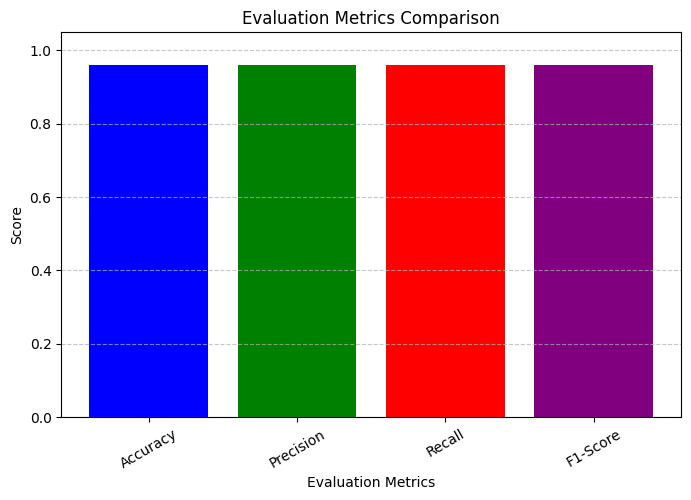

In [44]:
import matplotlib.pyplot as plt

# Define the evaluation metrics
metrics = ["Accuracy", "Precision", "Recall", "F1-Score"]
values = [accuracy, precision, recall, f1]  # Given metrics

# Create a bar chart
plt.figure(figsize=(8, 5))
plt.bar(metrics, values, color=['blue', 'green', 'red', 'purple'])
plt.ylim(0, 1.05)  # Set y-axis range from 0 to 1
plt.xlabel("Evaluation Metrics")
plt.ylabel("Score")
plt.title("Evaluation Metrics Comparison")
plt.xticks(rotation=30)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()


In [48]:
# Identify incorrect mappings in encoding.idx2type
incorrect_mappings = {key: value for key, value in encoding.idx2type.items() if isinstance(value, (int, float))}
print("Incorrect Mappings:", incorrect_mappings)

Incorrect Mappings: {}


In [49]:
# Fix incorrect mappings automatically
for key, value in incorrect_mappings.items():
    encoding.idx2type[key] = encoding.idx2type.get(value, f"Unknown ({value})")  # Replace or fallback

# Print the fixed mappings
print("Fixed idx2type Mappings:", encoding.idx2type)


Fixed idx2type Mappings: {0: 'Gather', 1: 'Hash Join', 2: 'Seq Scan', 3: 'Hash', 4: 'Bitmap Heap Scan', 5: 'Bitmap Index Scan', 6: 'Nested Loop', 7: 'Index Scan', 8: 'Merge Join', 9: 'Gather Merge', 10: 'Materialize', 11: 'BitmapAnd', 12: 'Sort', 13: 'Seq Scan', 14: 'Gather', 15: 'Hash', 16: 'Seq Scan', 17: 'Gather', 18: 'Hash Join', 19: 'Hash', 20: 'Seq Scan', 21: 'Gather', 22: 'Bitmap Index Scan', 23: 'Bitmap Heap Scan', 24: 'Bitmap Index Scan', 25: 'Bitmap Heap Scan', 26: 'Bitmap Index Scan', 27: 'Bitmap Heap Scan', 28: 'Bitmap Index Scan', 29: 'Gather', 30: 'Hash Join', 31: 'Hash', 32: 'Bitmap Heap Scan', 33: 'Bitmap Index Scan', 34: 'Gather', 35: 'Hash Join', 36: 'Seq Scan', 37: 'Hash', 38: 'Bitmap Heap Scan', 39: 'Bitmap Index Scan', 40: 'Gather', 41: 'Seq Scan', 42: 'Index Scan', 43: 'Nested Loop', 44: 'Index Scan', 45: 'Merge Join', 46: 'Merge Join', 47: 'Index Scan', 48: 'Index Scan', 49: 'Nested Loop', 50: 'Index Scan', 51: 'Gather Merge', 52: 'Materialize', 53: 'Nested Loop'

In [57]:
# Set model to evaluation mode
model.eval()
predicted_knobs = []
true_knobs = []
predicted_costs_list = []  # Temporary list for predicted costs
true_costs_list = []  # Temporary list for true costs

with torch.no_grad():
    # Get model predictions (both hint and cost)
    hint_outputs, cost_outputs = model(X_test_tensor)  

    # Convert logits to class indices for hint predictions
    _, predicted_hints = torch.max(hint_outputs, 1)  
    predicted_hints = predicted_hints.cpu().numpy()
    y_test_hints_np = y_hints_test_tensor.cpu().numpy()

    # Convert cost outputs to numpy (flattened for easier comparison)
    predicted_costs = cost_outputs.cpu().numpy().flatten()
    true_costs = y_cost_test_tensor.cpu().numpy().flatten()

# Convert numerical indices to knob names and store costs
for pred_idx, true_idx, pred_cost, true_cost in zip(predicted_hints, y_test_hints_np, predicted_costs, true_costs):
    true_knob = encoding.idx2type.get(true_idx, f"Unknown ({true_idx})")  # Handle missing mappings
    pred_knob = encoding.idx2type.get(pred_idx, f"Unknown ({pred_idx})")

    predicted_knobs.append(pred_knob)
    true_knobs.append(true_knob)
    predicted_costs_list.append(pred_cost)
    true_costs_list.append(true_cost)

# Convert cost lists into NumPy arrays
predicted_costs = np.array(predicted_costs_list)
true_costs = np.array(true_costs_list)

# Print first 10 predictions with associated costs for verification
print("\nSample Predictions with Costs:")
for i in range(min(10, len(true_knobs))):
    print(f"Sample {i+1}:")
    print(f"  True Knob: {true_knobs[i]} | True Cost: {true_costs[i]:.2f}")
    # | True Cost: {true_costs[i]:.2f}
    print(f"  Predicted Knob: {predicted_knobs[i]} | Predicted Cost: {predicted_costs[i]:.2f}")
    print("-" * 50)



Sample Predictions with Costs:
Sample 1:
  True Knob: Gather | True Cost: 0.61
  Predicted Knob: Gather | Predicted Cost: 0.60
--------------------------------------------------
Sample 2:
  True Knob: Seq Scan | True Cost: 0.86
  Predicted Knob: Seq Scan | Predicted Cost: 0.60
--------------------------------------------------
Sample 3:
  True Knob: Hash Join | True Cost: 0.60
  Predicted Knob: Hash Join | Predicted Cost: 0.57
--------------------------------------------------
Sample 4:
  True Knob: Bitmap Index Scan | True Cost: 0.59
  Predicted Knob: Bitmap Index Scan | Predicted Cost: 0.59
--------------------------------------------------
Sample 5:
  True Knob: Hash Join | True Cost: 0.55
  Predicted Knob: Hash Join | Predicted Cost: 0.59
--------------------------------------------------
Sample 6:
  True Knob: Sort | True Cost: 0.41
  Predicted Knob: Sort | Predicted Cost: 0.59
--------------------------------------------------
Sample 7:
  True Knob: Hash Join | True Cost: 0.52
 

In [58]:
# Track mismatches
mismatch_count = 0
total_samples = len(true_knobs)

# Store mismatched samples with associated costs
mismatched_samples = []

for i in range(total_samples):
    if true_knobs[i] != predicted_knobs[i]:  # Identify mismatches
        mismatch_count += 1
        cost_diff = abs(true_costs[i] - predicted_costs[i])  # Calculate cost difference
        mismatched_samples.append((i + 1, true_knobs[i], predicted_knobs[i], true_costs[i], predicted_costs[i], cost_diff))

# Print mismatch details
if mismatched_samples:
    print("\nMismatched Predictions with Costs:")
    for i, true_knob, predicted_knob, true_cost, predicted_cost, cost_diff in mismatched_samples[:10]:  # Print first 10 mismatches
        print(f"Sample {i}: ❌ Mismatch")
        print(f"  True Knob: {true_knob} | True Cost: {true_cost:.2f}")
        print(f"  Predicted Knob: {predicted_knob} | Predicted Cost: {predicted_cost:.2f}")
        print(f"  Cost Difference: {cost_diff:.2f}")
        print("-" * 50)

# Print overall error rate and average cost difference
if total_samples > 0:
    error_rate = (mismatch_count / total_samples) * 100
    avg_cost_diff = sum([x[5] for x in mismatched_samples]) / mismatch_count if mismatch_count > 0 else 0
    print(f"\nTotal Mismatches: {mismatch_count}/{total_samples} ({error_rate:.2f}%)")
    print(f"Average Cost Difference for Mismatches: {avg_cost_diff:.2f}")
else:
    print("\nNo samples found.")



Mismatched Predictions with Costs:
Sample 15: ❌ Mismatch
  True Knob: Hash Join | True Cost: 0.77
  Predicted Knob: Bitmap Index Scan | Predicted Cost: 0.57
  Cost Difference: 0.21
--------------------------------------------------
Sample 18: ❌ Mismatch
  True Knob: Seq Scan | True Cost: 0.70
  Predicted Knob: Bitmap Heap Scan | Predicted Cost: 0.60
  Cost Difference: 0.11
--------------------------------------------------
Sample 19: ❌ Mismatch
  True Knob: Gather | True Cost: 0.71
  Predicted Knob: Seq Scan | Predicted Cost: 0.58
  Cost Difference: 0.13
--------------------------------------------------
Sample 25: ❌ Mismatch
  True Knob: Seq Scan | True Cost: 0.65
  Predicted Knob: Gather | Predicted Cost: 0.59
  Cost Difference: 0.05
--------------------------------------------------
Sample 58: ❌ Mismatch
  True Knob: Hash Join | True Cost: 0.82
  Predicted Knob: Seq Scan | Predicted Cost: 0.59
  Cost Difference: 0.24
--------------------------------------------------
Sample 113: ❌ 

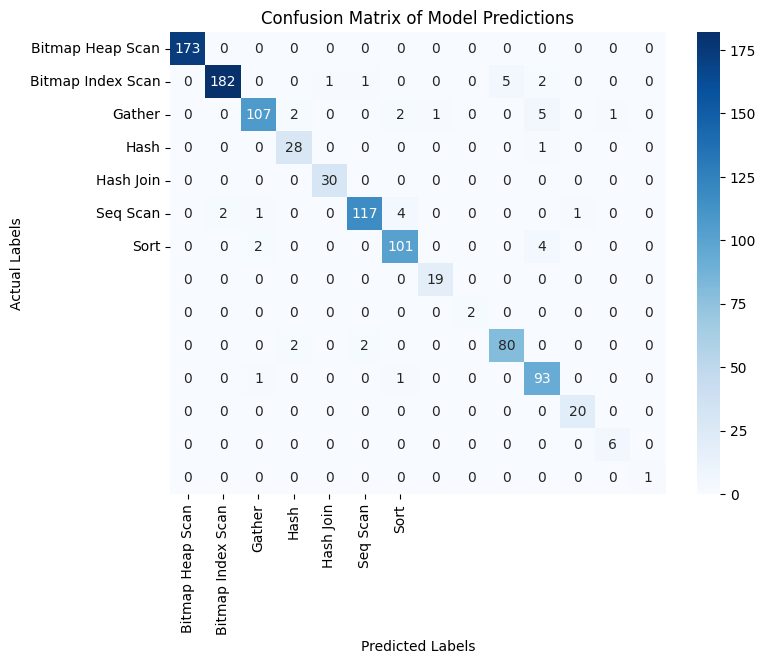


Average Cost Difference Per Knob Type (for Mismatches):
  Knob: Bitmap Heap Scan → Avg Cost Difference: 0.10
  Knob: Gather → Avg Cost Difference: 0.15
  Knob: Sort → Avg Cost Difference: 0.00
  Knob: Bitmap Index Scan → Avg Cost Difference: 0.24
  Knob: Seq Scan → Avg Cost Difference: 0.12
  Knob: Hash → Avg Cost Difference: 0.17
  Knob: Hash Join → Avg Cost Difference: 0.22


In [62]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Generate Confusion Matrix
cm = confusion_matrix(y_hints_test_tensor.cpu().numpy(), predicted_hints)

# Initialize dictionary using unique true knob names instead of numerical labels
cost_diffs = {knob: [] for knob in set(true_knobs)}

# Track cost difference per knob type (for mismatches)
for i in range(len(true_knobs)):
    if true_knobs[i] != predicted_knobs[i]:  # Mismatch case
        if true_knobs[i] not in cost_diffs:
            cost_diffs[true_knobs[i]] = []  # Ensure key exists
        cost_diffs[true_knobs[i]].append(abs(true_costs[i] - predicted_costs[i]))

# Compute mean cost difference per knob type
avg_cost_diff_per_knob = {k: (sum(v) / len(v) if v else 0) for k, v in cost_diffs.items()}

# Create heatmap for confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=sorted(set(true_knobs)), 
            yticklabels=sorted(set(predicted_knobs)))

plt.xlabel("Predicted Labels")
plt.ylabel("Actual Labels")
plt.title("Confusion Matrix of Model Predictions")

# Display confusion matrix
plt.show()

# Print cost differences for mismatched predictions
print("\nAverage Cost Difference Per Knob Type (for Mismatches):")
for knob, avg_cost in avg_cost_diff_per_knob.items():
    print(f"  Knob: {knob} → Avg Cost Difference: {avg_cost:.2f}")


In [63]:
from collections import defaultdict
import numpy as np

# Track cost differences for mismatched predictions
cost_diffs = defaultdict(list)

for i in range(len(true_knobs)):
    if true_knobs[i] != predicted_knobs[i]:  # Mismatch case
        cost_diffs[true_knobs[i]].append(abs(true_costs[i] - predicted_costs[i]))

# Compute mean cost difference per class
avg_cost_diff_per_class = {k: (sum(v) / len(v) if v else 0) for k, v in cost_diffs.items()}

# Print cost impact of misclassifications
print("\nAverage Cost Difference for Misclassified Hints:")
for hint, avg_cost in avg_cost_diff_per_class.items():
    print(f"  {hint}: {avg_cost:.2f} ms")

# Compute overall cost impact
total_cost_mismatch = sum([sum(v) for v in cost_diffs.values()])
print(f"\nTotal Cost Penalty due to Incorrect Hints: {total_cost_mismatch:.2f} ms")



Average Cost Difference for Misclassified Hints:
  Hash Join: 0.22 ms
  Seq Scan: 0.12 ms
  Gather: 0.15 ms
  Bitmap Index Scan: 0.24 ms
  Hash: 0.17 ms
  Bitmap Heap Scan: 0.10 ms

Total Cost Penalty due to Incorrect Hints: 6.36 ms


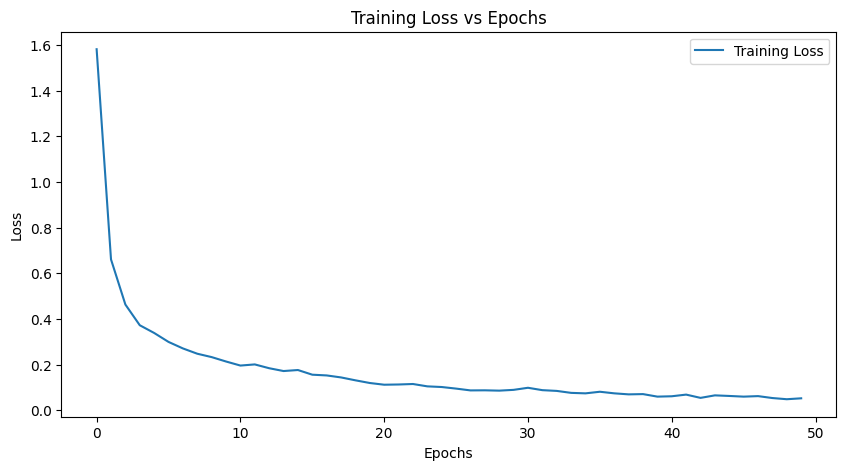

In [59]:
# After training, plot the loss curve
# Plot Training Loss
plt.figure(figsize=(10, 5))
plt.plot(range(num_epochs), train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss vs Epochs')
plt.legend()
plt.show()


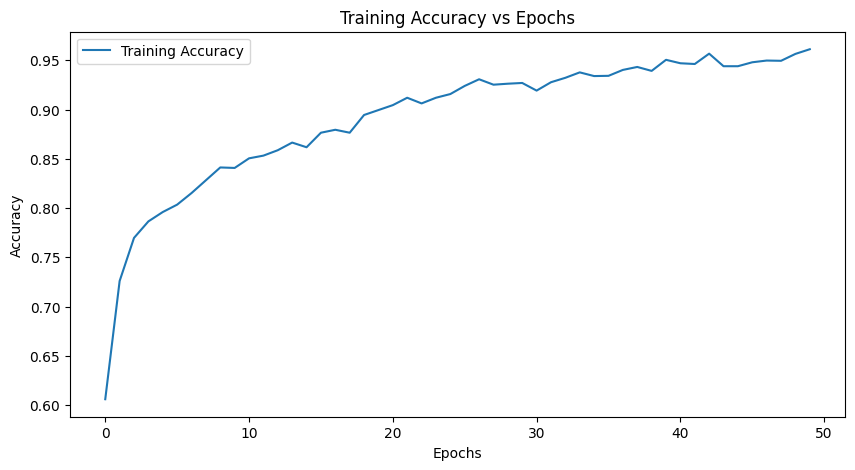

In [60]:
# Plot Training Accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(num_epochs), train_accuracies, label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy vs Epochs')
plt.legend()
plt.show()